In [26]:
using DifferentialEquations
using Plots
gr(fmt="png", size=(800, 300))

Plots.GRBackend()

In [31]:
include("HHModel.jl")

Main.HHModel

In [32]:
Na_m = HHModel.Kinetics(-20.0, 15.0, 0.0, _type=:instantaneous)
Na = HHModel.SimpleIonChannel("Persistent Sodium", :sodium, 20.0, 1, 0,
    Na_m, HHModel.Kinetics());

K_m = HHModel.Kinetics(-25.0, 5.0, 0.0)
K = HHModel.SimpleIonChannel("Persistent Potassium", :potassium, 15.0, 1, 0,
    K_m, HHModel.Kinetics());

L = HHModel.SimpleIonChannel("Leakage", :leak, 8.0, 0, 0,
    HHModel.Kinetics(), HHModel.Kinetics()
);

In [24]:
_model = HHModel.simpleConductanceModel([Na, K, L], (t) -> t > 40 ? 10 : 0)

#20 (generic function with 1 method)

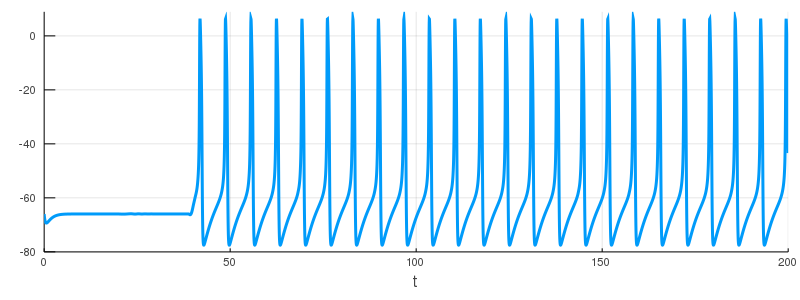

In [27]:
u0 = [-66.0, 0.045, 0.0, 0.0]
tspan = (0.0, 200.0)
_p = (E=(sodium=60.0, potassium=-90.0, leak=-80.0),)

prob = ODEProblem(_model, u0, tspan, _p)
sol = solve(prob, Tsit5(), dt=0.01);

plot(sol, vars=(1), legend=nothing)

---

In [26]:
function simpleConductanceModel(channels::Vector{HHModel.SimpleIonChannel}, stim::Function)
    nchannel = length(channels)
    nvar = HHModel.dof(channels)
    
    return (du, u, p, t) -> begin
        v = u[1]
        param = u[2:end-1]
        var_idx = 1
        dvar_idx = 1
        
        _current = zeros(nchannel)
        for (idx, item) in enumerate(channels)
            (_m, _h) = HHModel.dof(item)
            
            # retrive activation or inactivation variable
            if _m == 1
                _m_val = param[var_idx]
                var_idx = var_idx + 1
            else
                _m_val = 1
            end
            
            if _h == 1
                _h_val = param[var_idx]
                var_idx = var_idx + 1
            else
                _h_val = 1
            end
            
            # step update
            (_item_i, _item_dm, _item_dh) = HHModel.step(item, V=v, m=_m_val, h=_h_val, E=p.E[item.ion])
            _current[idx] = _item_i
            
            # udpate du value for activation or inactivation variable
            if _m == 1
                du[1 + dvar_idx] = _item_dm
                dvar_idx = dvar_idx + 1
            end
            
            if _h == 1
                du[1 + dvar_idx] = _item_dh
                dvar_idx = dvar_idx + 1
            end
        end
        
        # udpate dV and current input
        du[1] = stim(t) - sum(_current)
        u[end] = stim(t)
        du
    end
end

simpleConductanceModel (generic function with 1 method)

In [16]:
function simpleConductanceModel(channels::Vector{HHModel.SimpleIonChannel}, stim::Function)
    nchannel = length(channels)
    nvar = HHModel.dof(channels)
    return (du, u, p, t) -> begin
        i = Vector{Float64}(undef, nchannel)
        d_var = Vector{Float64}(undef, nvar)
        var_count = 1
        var_idx = 1
        
        V = u[1]
        
        for idx = 1:nchannel
            _ion = channels[idx].ion
            _dof_ch = HHModel.dof(channels[idx])
            
            if _dof_ch[1] == 1
                _m = u[var_idx]
                var_idx = var_idx + 1
            else
                _m = 1
            end
            
            if _dof_ch[2] == 1
                _h = u[var_idx]
                var_idx = var_idx + 1
            else
                _h = 1
            end
            
            (_i, _dm, _dh) = HHModel.step(channels[idx], V=V, m=_m, h=_h, E=p.E[_ion])
            i[idx] = _i
            
            if ~isnothing(_dm)
                d_var[var_count] = _dm
                var_count = var_count + 1
            end
            if ~isnothing(_dh)
                d_var[var_count] = _dh
                var_count = var_count + 1
            end
        end
        
        du[1] = stim(t) - sum(i)
        du[2:end-1] = d_var
        u[end] = stim(t)
        
        du, u, p, t
    end
end

simpleConductanceModel (generic function with 1 method)

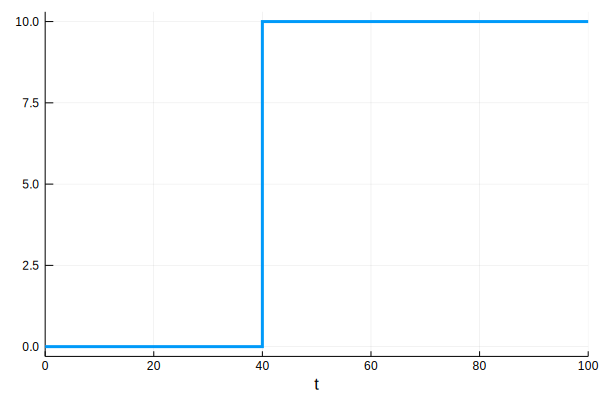

In [301]:
stimulus = (t) -> t > 40 ? 10 : 0
_model = simpleConductanceModel([Na, K, L], stimulus)

u0 = [-66.0, 0.045, 0.0]
tspan = (0.0, 100.0)
_p = (E=(sodium=60.0, potassium=-90.0, leak=-80.0),)

prob = ODEProblem(_model, u0, tspan, _p)
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8);

plot(sol, vars=(3), legend=nothing)

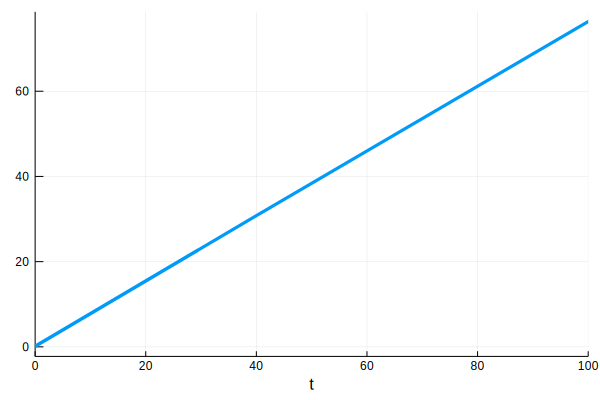

In [302]:
plot(sol, vars=(2), legend=nothing)